------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [22]:
!python --version

Python 3.12.4


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [23]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
# from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [24]:
# download sentiment lexicon
# !wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
# !wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [25]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [26]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [27]:
# YOUR CODE HERE
# load sent lex into dic
sent_lex = {}
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    typ, Len, Word, pos1, stem, prior = line.strip().split(" ")
    word = Word.split('=')[1]

    # sent = 1 if 'postive', -1 if 'negative', 0 if 'neutral' or 'both'
    if prior.split('=')[1] =='positive':
        prior = 1
    elif prior.split('=')[1] =='negative':
        prior = -1
    else:
        prior = 0
    sent_lex[word] = prior

def binary_score(review, sent_lex, threshold=8):
    score = 0
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            if token in sent_lex:
                score += sent_lex[token.lower()]

    return 1 if score >= threshold else 0

def accuracy1(results, inputs):
    TPTN = 0
    TPTNFPFN = len(results)

    for i, r in enumerate(inputs):
        bool1 = r["sentiment"] == 'NEG' and results[i] == 0
        bool2 = r["sentiment"] == 'POS' and results[i] == 1
        if bool1 or bool2:
            TPTN += 1

    accuracy = TPTN / TPTNFPFN
    # print("Accuracy:", accuracy)
    return accuracy

def accuracy2(results, inputs):
    TPTN = 0
    TPTNFPFN = len(results)

    for i, r in enumerate(inputs):
        if r["sentiment"] == results[i]:
            TPTN += 1

    accuracy = TPTN / TPTNFPFN
    # print("Accuracy:", accuracy)
    return accuracy

In [28]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = list(map(lambda r: binary_score(r,sent_lex), reviews))

token_accuracy = accuracy1(token_results,reviews)
print("Token-based accuracy:", token_accuracy)

Token-based accuracy: 0.674


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [29]:
# YOUR CODE HERE
magnitude_sent_lex = {}
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  magnitude_sent_lex = {}
  for line in f:
    typ, Len, Word, pos1, stem, prior = line.strip().split(" ")

    word = Word.split('=')[1]
    magnitude = 2 if typ.split('=')[1] == 'strongsubj' else 1
    
    # sent = 1 if 'postive', -1 if 'negative', 0 if 'neutral' or 'both'
    if prior.split('=')[1] =='positive':
        prior = 1
    elif prior.split('=')[1] =='negative':
        prior = -1
    else:
        prior = 0
    magnitude_sent_lex[word] = prior*magnitude

In [30]:
# madnitude_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
magnitude_results = list(map(lambda r: binary_score(r,magnitude_sent_lex), reviews))

magnitude_accuracy = accuracy1(magnitude_results,reviews)
print("Magnitude-based accuracy:", magnitude_accuracy)

Magnitude-based accuracy: 0.6795


#### (Q.1.3) Make a barplot of the two results (0.5pt)

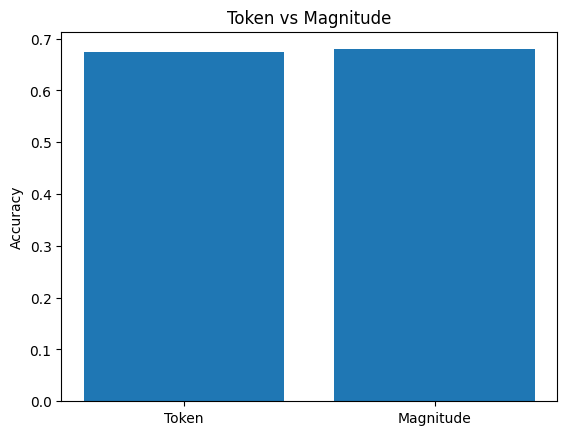

In [31]:
# YOUR CODE HERE
plt.bar(['Token', 'Magnitude'], [token_accuracy, magnitude_accuracy])
plt.ylabel('Accuracy')
plt.title('Token vs Magnitude')
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

$\textbf{Answer}$

We can solve this by using dynamic thresholds, which changes per document based on the documents length. We suggest using a value proportional to one over the document length, where the proportionality constant is a hyperparameter to be set during training.

To get more specfic, we can think of a positive review as having a rate of positive words $\gamma$, so for $n$ words, there would be $\gamma n$ positive words. Then, we can think of the binary score $S$ as a sum over positive words of the entire review, so $S \propto \gamma L$. We want to threshold based on the rate of postive words, not on the total number of positive words. Without dynamic thresholding, we use 
$$S \geq \alpha$$
With dynamic threshold, we get
$$\gamma \propto \frac SL \geq \frac \alpha L$$
Here, $\alpha$ is a scale parameter which we will not tune but set to 1.

In [32]:
# YOUR CODE HERE
# madnitude_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.

magnitude_results= []
for r in reviews:
    doc_len = sum([len(s) for s in r["content"]])
    dynamic_threshold = 1/doc_len
    magnitude_results.append(binary_score(r, magnitude_sent_lex, dynamic_threshold))

threshold_accuracy = accuracy1(magnitude_results, reviews)
print("Threshold-based accuracy:", threshold_accuracy)

Threshold-based accuracy: 0.648


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

$\textbf{Answer}$

For a test document, we score each class based on the sum of conditional log likelihoods of words. For a word that is unseen in one class but seen in the other, if we skip that word for one class at test time, effectively we set the conditional likelihood of that word to zero for that class while we do consider its contibution to the score for the other class.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [33]:
# YOUR CODE HERE
def train_NB(C, D):
    
    Ndoc = len(D)
    log_prior = {}
    log_likelihood = {}
    big_doc = {}

    # Make vocab for all documents
    V_pos = set()
    V_neg = set()
    for doc in D:
        if doc['sentiment'] == 'POS':
            for s in doc["content"]:
                for w, _ in s:
                    V_pos.add(w.lower())
        elif doc['sentiment'] == 'NEG':
            for s in doc["content"]:
                for w, _ in s:
                    V_neg.add(w.lower())
    
    V = V_pos.intersection(V_neg)      # Train only on words that appear in both POS and NEG documents

    # Calculate P(w|c)
    for c in C:
        big_doc[c] = [doc for doc in D if doc["sentiment"] == c]
        Nc = len(big_doc[c])
        log_prior[c] = np.log(Nc/Ndoc) if Nc > 0 else -np.inf
        word_counts = Counter()
        # Count occurences of each w in big_doc[c]
        for doc in big_doc[c]:
            for sentence in doc['content']:
                for word, pos_tag in sentence:
                    word_counts[word.lower()] += 1
        
        sum1 = sum(word_counts[v] for v in V)

        for w in V:
            log_likelihood[w,c] = np.log(word_counts[w]) - np.log(sum1) if word_counts[w] > 0 else -np.inf                 # no smoothing yet?
    
    return log_prior,log_likelihood,V_pos,V_neg
        
      
def test_NB(testdoc,log_prior,log_likelihood,C,V_pos,V_neg):
    V_int = V_pos & V_neg
    sum_c = {}
    for c in C:
        sum_c[c] = log_prior[c]
        for sentence in testdoc['content']:
            for word, pos_tag in sentence:
                if word in V_int:
                    sum_c[c] += log_likelihood.get((word, c), 0)
    return max(sum_c, key=sum_c.get)

In [34]:
train_set = [r for r in reviews if r['cv'] < 900]
test_set = [r for r in reviews if r['cv'] >= 900]

log_prior, log_likelihood, V_pos,V_neg =train_NB(['POS','NEG'], train_set)
test_results = [test_NB(testdoc, log_prior, log_likelihood, ['POS','NEG'], V_pos,V_neg) for testdoc in test_set]

nb_accuracy = accuracy2(test_results,test_set)
print("Naive Bayes accuracy:", nb_accuracy)

Naive Bayes accuracy: 0.845


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [35]:
# YOUR CODE HERE
train_set = [r for r in reviews if r['sentiment'] == 'POS' and r['cv'] < 900] + [r for r in reviews if r['sentiment'] == 'NEG' and r['cv'] < 90]    
test_set_1 = [r for r in reviews if r['sentiment'] == 'POS' and r['cv'] >= 900] + [r for r in reviews if r['sentiment'] == 'NEG' and 900 <= r['cv'] < 910]
test_set_2 = [r for r in reviews if r['sentiment'] == 'NEG' and r['cv'] >= 900] + [r for r in reviews if r['sentiment'] == 'POS' and 900 <= r['cv'] < 910]


log_prior, log_likelihood, V_pos,V_neg = train_NB(['POS','NEG'], train_set)

test_results_1 = [test_NB(testdoc, log_prior, log_likelihood, ['POS','NEG'], V_pos,V_neg) for testdoc in test_set_1]
test_1_accuracy = accuracy2(test_results_1, test_set_1)
print("same bias in test accuracy:", test_1_accuracy)

test_results_2 = [test_NB(testdoc, log_prior, log_likelihood, ['POS','NEG'], V_pos,V_neg) for testdoc in test_set_2]
test_2_accuracy = accuracy2(test_results_2, test_set_2)
print("opposite bias in test accuracy:", test_2_accuracy)

same bias in test accuracy: 0.9090909090909091
opposite bias in test accuracy: 0.18181818181818182


$\textbf{Answer}$
We can see the accuract is very high, but this is misleading. The classifier is not learning much from the negative reviews, so it is probably not generalizing well to unseen data. The classifier is just predicting the majority class, which is positive reviews. This is a case of class imbalance, and we should use other metrics like precision, recall, and F1 score to evaluate the classifier.

## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$
for a word $w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [36]:
# YOUR CODE HERE
def train_NB_smoothing(C, D, **kwargs):
    kappa = kwargs.get('kappa', 1)
    
    Ndoc = len(D)
    log_prior = {}
    log_likelihood = {}
    big_doc = {}

    # Make vocab for all documents
    V_pos = set()
    V_neg = set()
    for doc in D:
        if doc['sentiment'] == 'POS':
            for s in doc["content"]:
                for w, _ in s:
                    V_pos.add(w.lower())
        elif doc['sentiment'] == 'NEG':
            for s in doc["content"]:
                for w, _ in s:
                    V_neg.add(w.lower())
    
    V = V_pos.union(V_neg)      # Train every word that appears in either POS or NEG documents

    # Calculate P(w|c)
    for c in C:
        big_doc[c] = [doc for doc in D if doc["sentiment"] == c]
        Nc = len(big_doc[c])
        log_prior[c] = np.log(Nc/Ndoc) if Nc > 0 else -np.inf
        word_counts = Counter()
        # Count occurences of each w in big_doc[c]
        for doc in big_doc[c]:
            for sentence in doc['content']:
                for word, pos_tag in sentence:
                    word_counts[word.lower()] += 1
        
        sum1 = sum(word_counts[v] for v in V)

        for w in V:
            log_likelihood[w,c] = np.log(word_counts[w] + kappa) - np.log(sum1 + len(V)*kappa)
            
    return log_prior,log_likelihood,V_pos,V_neg

In [37]:
train_set = [r for r in reviews if r['cv'] < 900]
test_set = [r for r in reviews if r['cv'] >= 900]

log_prior, log_likelihood, V_pos,V_neg = train_NB_smoothing(['POS','NEG'], train_set, kappa = 1)

test_results = [test_NB(testdoc, log_prior, log_likelihood, ['POS','NEG'], V_pos,V_neg) for testdoc in test_set]
NB_smooth_accuracy = accuracy2(test_results, test_set)
print("Naive Bayes with smoothing accuracy:", NB_smooth_accuracy)

Naive Bayes with smoothing accuracy: 0.855


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [38]:
# YOUR CODE HERE
def round_robin_split(data, n_splits=10):
    """
    Split data into `n_splits` using round-robin splitting.
    Each split i contains every nth item from data.
    """
    folds = [[] for _ in range(n_splits)]
    for index, doc in enumerate(data):
        folds[index % n_splits].append(doc)
    return folds

def cross_validate_NB(data, train_classifier, test_function, **kwargs):
    # Perform round-robin split
    n_splits = kwargs.get('n_splits', 10)
    folds = round_robin_split(data, n_splits=n_splits)
    accuracies = []

    # Perform N-fold cross-validation
    for i in range(n_splits):
        # Prepare training and test sets
        test_fold = folds[i]
        train_folds = [folds[j] for j in range(n_splits) if j != i]
        train_data = [doc for fold in train_folds for doc in fold]

        # Train the classifier on the training data
        log_prior, log_likelihood, V_pos, V_neg = train_classifier(['POS', 'NEG'], train_data, **kwargs)


        # Test the classifier on the test data
        test_results = [test_function(testdoc, log_prior, log_likelihood, ['POS', 'NEG'], V_pos, V_neg) for testdoc in test_fold]
        
        # Calculate accuracy for this fold
        accuracy = accuracy2(test_results, test_fold)
        accuracies.append(accuracy)

        print(f"Accuracy for fold {i + 1}: {accuracy:.4f}")

    # Calculate average accuracy
    average_accuracy = np.mean(accuracies)
    print(f"\nAverage accuracy across all folds: {average_accuracy:.4f}")
    return accuracies, average_accuracy

accuracies, average_accuracy = cross_validate_NB(reviews, train_NB_smoothing, test_NB, kappa=1, n_splits=10)

Accuracy for fold 1: 0.7750
Accuracy for fold 2: 0.8350
Accuracy for fold 3: 0.8400
Accuracy for fold 4: 0.8550
Accuracy for fold 5: 0.7800
Accuracy for fold 6: 0.8350
Accuracy for fold 7: 0.8450
Accuracy for fold 8: 0.8000
Accuracy for fold 9: 0.8500
Accuracy for fold 10: 0.8450

Average accuracy across all folds: 0.8260


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [39]:
# YOUR CODE HERE

# IMPLEMENT FORMULA DIRECTLY
def variance(accuracies):
    N = len(accuracies)
    mean = sum(accuracies) / N
    variance = sum((x - mean)**2 for x in accuracies) / N
    return variance
print(f"Variance: {variance(accuracies):.4f}")

Variance: 0.0008


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [40]:
# YOUR CODE HERE
def train_NB_smoothing_stemmed(C, D, **kwargs):
        kappa = kwargs.get('kappa', 1)
        stemmer = kwargs.get('stemmer', PorterStemmer())
        
        Ndoc = len(D)
        log_prior = {}
        log_likelihood = {}
        big_doc = {}
    
        # Make vocab for all documents
        V_pos = set()
        V_neg = set()
        for doc in D:
            if doc['sentiment'] == 'POS':
                for s in doc["content"]:
                    for w, _ in s:
                        V_pos.add(stemmer.stem(w))
            elif doc['sentiment'] == 'NEG':
                for s in doc["content"]:
                    for w, _ in s:
                        V_neg.add(stemmer.stem(w))
        
        V = V_pos.union(V_neg)
    
        # Calculate P(w|c)
        for c in C:
            big_doc[c] = [doc for doc in D if doc["sentiment"] == c]
            Nc = len(big_doc[c])
            log_prior[c] = np.log(Nc/Ndoc) if Nc > 0 else -np.inf
            word_counts = Counter()
            # Count occurences of each w in big_doc[c]
            for doc in big_doc[c]:
                for s in doc['content']:
                    for w, _ in s:
                        word_counts[stemmer.stem(w)] += 1
            
            sum1 = sum(word_counts[v] for v in V)
    
            for w in V:
                log_likelihood[w,c] = np.log(word_counts[w] + kappa) - np.log(sum1 + len(V)*kappa)
        
        return log_prior,log_likelihood,V_pos,V_neg


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [41]:
# YOUR CODE HERE
accuracies, average_accuracy = cross_validate_NB(reviews, train_NB_smoothing_stemmed, test_NB, kappa=1, n_splits=10)
print(f'Variances: {variance(accuracies):.4f}')

Accuracy for fold 1: 0.7000
Accuracy for fold 2: 0.7850
Accuracy for fold 3: 0.7950
Accuracy for fold 4: 0.7850
Accuracy for fold 5: 0.6950
Accuracy for fold 6: 0.7800
Accuracy for fold 7: 0.8100
Accuracy for fold 8: 0.7650
Accuracy for fold 9: 0.7950
Accuracy for fold 10: 0.7900

Average accuracy across all folds: 0.7700
Variances: 0.0014


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [42]:
# YOUR CODE HERE
C = ['POS','NEG']
D = train_set

log_prior,log_likelihood,V_pos,V_neg = train_NB_smoothing_stemmed(C, D)
V_stemmed = V_pos.union(V_neg)
print(f'Number of features with stemming: {len(V_stemmed)}')

log_prior,log_likelihood,V_pos,V_neg = train_NB_smoothing(C, D)
V_not_stemmed = V_pos.union(V_neg)
print(f'Number of features without stemming: {len(V_not_stemmed)}')

Number of features with stemming: 32404
Number of features without stemming: 45348


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [43]:
# YOUR CODE HERE
def train_NB_smoothing_ngrams(C, D, **kwargs):
    kappa = kwargs.get('kappa', 1)
    tri = kwargs.get('tri', False)
    
    Ndoc = len(D)
    log_prior = {}
    log_likelihood = {}
    big_doc = {}

    # Make vocab for all documents
    V_pos = set()
    V_neg = set()
    for doc in D:
        if doc['sentiment'] == 'POS':
            for s in doc["content"]:
                words = [word.lower() for word, pos in s]
                V_pos.update(ngrams(words,1))
                V_pos.update(ngrams(words,2))
                if tri: V_pos.update(ngrams(words,3))
        elif doc['sentiment'] == 'NEG':
            for s in doc["content"]:
                words = [word.lower() for word, pos in s]
                V_neg.update(ngrams(words,1))
                V_neg.update(ngrams(words,2))
                if tri: V_neg.update(ngrams(words,3))
    
    V = V_pos.union(V_neg)

    # Calculate P(w|c)
    for c in C:
        big_doc[c] = [doc for doc in D if doc["sentiment"] == c]
        Nc = len(big_doc[c])
        log_prior[c] = np.log(Nc/Ndoc) if Nc > 0 else -np.inf
        ngrams_counts = Counter()
        # Count occurences of each w in big_doc[c]
        for doc in big_doc[c]:
            for s in doc['content']:
                words = [word.lower() for word, pos in s]
                ngrams_counts.update(ngrams(words,1))
                ngrams_counts.update(ngrams(words,2))
                if tri: ngrams_counts.update(ngrams(words,3))
        sum1 = sum(ngrams_counts[ngram] for ngram in V)
        
        for ngram in V:
            log_likelihood[ngram, c] = np.log(ngrams_counts[ngram] + kappa) - np.log(sum1 + len(V)*kappa)
            
    return log_prior,log_likelihood,V_pos,V_neg

def test_NB_ngrams(testdoc,log_prior,log_likelihood,C,V_pos,V_neg,tri=False):
    V_int = V_pos & V_neg
    sum1 = {}
    for c in C:
        sum1[c] = log_prior[c]
        for sentence in testdoc['content']:
            words = [word.lower() for word, pos in sentence]
            
            for ngram in ngrams(words,1):
                if ngram in V_int:
                    sum1[c] += log_likelihood.get((ngram, c), 0)
            
            for ngram in ngrams(words,2):
                if ngram in V_int:
                    sum1[c] += log_likelihood.get((ngram, c), 0)
            
            if tri:
                for ngram in ngrams(words,3):
                    if ngram in V_int:
                        sum1[c] += log_likelihood.get((ngram, c), 0)
                
    return max(sum1, key=sum1.get)  


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


In [44]:
# YOUR CODE HERE
accuracies_bi, average_accuracy_bi = cross_validate_NB(reviews, train_NB_smoothing_ngrams, test_NB_ngrams, tri=False)
print(f'Average accuracy for bigrams: {average_accuracy_bi:.4f}')

accuracies_tri, average_accuracy_tri = cross_validate_NB(reviews, train_NB_smoothing_ngrams, test_NB_ngrams, tri=True)
print(f'Average accuracy for trigrams: {average_accuracy_tri:.4f}')

Accuracy for fold 1: 0.7700
Accuracy for fold 2: 0.8350
Accuracy for fold 3: 0.8250
Accuracy for fold 4: 0.8750
Accuracy for fold 5: 0.8100
Accuracy for fold 6: 0.8400
Accuracy for fold 7: 0.8600
Accuracy for fold 8: 0.8050
Accuracy for fold 9: 0.8500
Accuracy for fold 10: 0.8200

Average accuracy across all folds: 0.8290
Average accuracy for bigrams: 0.8290
Accuracy for fold 1: 0.7450
Accuracy for fold 2: 0.7750
Accuracy for fold 3: 0.8150
Accuracy for fold 4: 0.8450
Accuracy for fold 5: 0.7750
Accuracy for fold 6: 0.7950
Accuracy for fold 7: 0.8200
Accuracy for fold 8: 0.7900
Accuracy for fold 9: 0.8250
Accuracy for fold 10: 0.8050

Average accuracy across all folds: 0.7990
Average accuracy for trigrams: 0.7990


In [45]:
log_prior,log_likelihood,V_pos,V_neg = train_NB_smoothing(C, D)
V_uni = V_pos.union(V_neg)
print(f'Number of features with unigrams: {len(V_uni)}')

log_prior,log_likelihood,V_pos,V_neg = train_NB_smoothing_ngrams(C, D, tri=False)
V_uni_bi = V_pos.union(V_neg)
print(f'Number of features with unigrams+bigrams: {len(V_uni_bi)}')

log_prior,log_likelihood,V_pos,V_neg = train_NB_smoothing_ngrams(C, D, tri=True)
V_uni_bi_tri = V_pos.union(V_neg)
print(f'Number of features with unigrams+bigrams+trigrams: {len(V_uni_bi_tri)}')

Number of features with unigrams: 45348
Number of features with unigrams+bigrams: 465262
Number of features with unigrams+bigrams+trigrams: 1346107


$\textbf{Answer}$

If we have a vocabulary of length $V$, the number of possible unigrams made of this vocabulary is $V$, the number of possible bigrams is $V^2$, and the number of possible trigrams is $V^3$. 
Therefore if the words in sentences were totally random we would expect the number of features to increase quadratically using bigrams and cubically using trigrams.

However, in practice, we don't see the increase in the number of features to be this high. This is because the words in sentences are not totally random and some bigrams(trigrams) are possible(and occuring) in a legit sentence while others are not. 

From data we see a linear increase. This may be because we are using a specific dataset, out of which we are extracting n-grams. Since every sentence of length $n$ has $n$ unigrams, $n-1$ bigrams, and $n-2$ trigrams, the maximum number of unigrams+bigrams that can be extracted from each sentence is $2n-1$ and the maximum number of unigrams+bigrams+trigrams that can be extracted from each sentence is $3n-3$, which is a linear scaling. 
In practice, again however, we see higher increase going from unigrams to bigrams to trigrams. This is because the unigrams are more likely to be seen multiple times, while bigrams and trigrams are each less likely to be seen multiple times.

The number of features will therefore be more than the number of features at Q2.8 because we are adding more n-grams to the feature set.


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [46]:
# YOUR CODE HERE

def cross_validate_SVM(data, train_classifier, V, V_dict, n_splits=10):
    # Perform round-robin split
    folds = round_robin_split(data, n_splits=n_splits)
    accuracies = []

    # Perform N-fold cross-validation
    for i in range(n_splits):
        # Prepare training and test sets
        test_fold = folds[i]
        train_folds = [folds[j] for j in range(n_splits) if j != i]
        train_data = [doc for fold in train_folds for doc in fold]

        SVM = train_classifier(train_data, V_dict)

        X_test = np.zeros((len(test_fold), len(V_dict)))
        y_test = np.zeros(len(test_fold))
        
        for i, doc in enumerate(test_fold):
            word_counts = Counter(w for s in doc['content'] for w, _ in s if w in V_dict)
            for w, count in word_counts.items():
                X_test[i, V_dict[w]] = count
            y_test[i] = 1 if doc['sentiment'] == 'POS' else 0
        
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Test the classifier and calculate accuracy
        predictions = SVM.predict(X_test)
        accuracy = np.mean(predictions == y_test)
        print(accuracy)
        accuracies.append(accuracy)

    # Calculate average accuracy
    average_accuracy = np.mean(accuracies)
    print(f"\nAverage accuracy across all folds: {average_accuracy:.4f}")
    return accuracies, average_accuracy

def words_vocab(D):
    # Make vocab for all documents
    V = set()
    for doc in D:
        for s in doc["content"]:
            for w, _ in s:
                V.add(w)
    
    V = sorted(V)
    V_dict = {word: i for i, word in enumerate(V)}
    return V, V_dict

def train_SVM(train_fold, V_dict):

    X_train = np.zeros((len(train_fold), len(V_dict)))
    y_train = np.zeros(len(train_fold))
    for i, doc in enumerate(train_fold):
        word_counts = Counter(w for s in doc['content'] for w, _ in s if w in V_dict)
        for w, count in word_counts.items():
            X_train[i, V_dict[w]] = count
        y_train[i] = 1 if doc['sentiment'] == 'POS' else 0

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Train the SVM
    SVM = sk.svm.LinearSVC()
    SVM.fit(X_train, y_train)
    return SVM

V , V_dict = words_vocab(reviews)
C = ['POS','NEG']
D = reviews
accuracies, average_accuracy = cross_validate_SVM(reviews, train_SVM, V, V_dict)

0.82


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.81


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.805


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.835
0.835
0.855
0.845


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.86


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.865
0.835

Average accuracy across all folds: 0.8365


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



#### (Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [47]:
# YOUR CODE HERE
def words_POS_vocab(D):
    # Make vocab for all documents
    V = set()
    for doc in D:
        for s in doc["content"]:
            for w, POS in s:
                V.add((w,POS))
    V = sorted(V)
    V_dict = {word: i for i, word in enumerate(V)}
    return V, V_dict

D = reviews
V, V_dict = words_POS_vocab(D)


def train_SVM_POS(D, train_fold, V_dict):

    X_train = np.zeros((len(train_fold), len(V_dict)))
    y_train = np.zeros(len(train_fold))
    for i, doc in enumerate(train_fold):
        word_POS_counts = Counter(tuple(word_POS) for s in doc['content'] for word_POS in s if tuple(word_POS) in V_dict)
        for word_POS, count in word_POS_counts.items():
            X_train[i, V_dict[word_POS]] = count
        y_train[i] = 1 if doc['sentiment'] == 'POS' else 0

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Train the SVM
    SVM = sk.svm.LinearSVC()
    SVM.fit(X_train, y_train)
    return SVM

def cross_validate_SVM_POS(data, train_classifier, V, V_dict, n_splits=10):
    # Perform round-robin split
    folds = round_robin_split(data, n_splits=n_splits)
    accuracies = []

    # Perform N-fold cross-validation
    for i in range(n_splits):
        # Prepare training and test sets
        test_fold = folds[i]
        train_folds = [folds[j] for j in range(n_splits) if j != i]
        
        train_data = [doc for fold in train_folds for doc in fold]

        SVM = train_classifier(D, train_data, V_dict)

        X_test = np.zeros((len(test_fold), len(V_dict)))
        y_test = np.zeros(len(test_fold))
        
        for i, doc in enumerate(test_fold):
            word_POS_counts = Counter(tuple(word_POS) for s in doc['content'] for word_POS in s if tuple(word_POS) in V_dict)
            for word_POS, count in word_POS_counts.items():
                X_test[i, V_dict[word_POS]] = count
            y_test[i] = 1 if doc['sentiment'] == 'POS' else 0

        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Test the classifier and calculate accuracy
        predictions = SVM.predict(X_test)
        accuracy = np.mean(predictions == y_test)
        print(accuracy)
        accuracies.append(accuracy)

    # Calculate average accuracy
    average_accuracy = np.mean(accuracies)
    print(f"\nAverage accuracy across all folds: {average_accuracy:.4f}")
    print(f"Variance: {variance(accuracies):.4f}")
    return accuracies, average_accuracy

V , V_dict = words_POS_vocab(reviews)
C = ['POS','NEG']
D = reviews
accuracies, average_accuracy = cross_validate_SVM_POS(reviews,train_SVM_POS, V, V_dict)

0.83


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.81


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.81


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.835
0.85


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.85


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.865


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.835
0.86
0.83

Average accuracy across all folds: 0.8375
Variance: 0.0003


$\textbf{Answer}$

It does increase the accuracy. This may be because the model can better discriminte the meaning of indivudual words based on the POS tag.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [48]:
# YOUR CODE HERE
valid = ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']   

def words_POS_vocab_valid(D, valid):
    # Make vocab for all documents
    V = set()
    for doc in D:
        for s in doc["content"]:
            for w, POS in s:
                if POS in valid:
                    V.add((w,POS))
    V = sorted(V)
    V_dict = {word: i for i, word in enumerate(V)}
    return V, V_dict

C = ['POS','NEG']
D = reviews
V, V_dict = words_POS_vocab_valid(D, valid)
accuracies, average_accuracy = cross_validate_SVM_POS(reviews,train_SVM_POS, V, V_dict)


0.84
0.835


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.82
0.855


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.85
0.85


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.865


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.86


/home/viki/miniconda3/envs/cv1/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.855
0.8

Average accuracy across all folds: 0.8430
Variance: 0.0004


$\textbf{Answer}$

It does increase the accuracy. Closed class words carry less information on sentiment, so this may be because the model is not is not thrown off by uninformative words.

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?


token score : 0.674 \
magnitude token score : 0.6795 \
dynamic threshold: 0.648 

NB: 0.845 \
NB skewed: 0.91 \
NB smooth: 0.855 

crossvalid: \
NB smooth: avg 0.8260   var 0.0004 \
NB stemming: avg 0.77 \
NB bigrams: avg 0.829 \
NB bigrams+trigrams: avg 0.799 

SVM: avg 0.8365 \
SVM POS: avg 0.8375 \
SVM important POS: avg 0.8430 


$\textbf{Answer}$

In this practical, we have implemented three different approaches to classify the sentiment of movie reviews. 

#### Lexicon-based approach
In this approach we used a sentiment lexicon to classify the sentiment of each word in a document. The simplest model relied only on difference between amounts of the positive and negative words in document reaching accuracy of 0.674.
We then incorporated the magnitude of the prioprolarity of the words, which increased the accuracy to 0.6795. We believe this is because the words that are more extreme in their prioprolarity carry more information on the overall sentiment of the review. 
We also tried to implement a dynamic threshold, which decreased the accuracy to 0.648. The reason for worse performance may be that we didnt perform any tuning on the hyperparameters in the dynamic threshold formula.
It is important to note that in this implementation we only considered one possible pos tag per word, which may cause the model to misinterpret some words.

#### Naive Bayes approach
The baseline Naive Bayes classifier using a simple BoW representation of documents reached an accuracy of 0.845, which seems significantly better than the lexicon-based classifier. 
In this first implementation we skipped the words that only occur in training documents of one of the classes and not the other, to avoid zeroing out the probabilities. Omitting these words may, however, lead to a loss of some information.
To tackle this differently we also implemented Laplace smoothing to be able to use all the words occuring in all the documents in our vocabulary, which increased the accuracy to 0.855. Using the 10-fold cross-vallidation, however, we only got average accuracy of 0.826.

To disambiguate the different words possibly meaning the same thing we implemented stemming which decreased both the size of the vocabulary to 3/4 of the original size and the average accuracy to 0.77. This decrease may mean that we generalized the words too much, ignoring the sentiment that different variations may have carried.

To take into account the order of the words or connections between them we also included bigrams and trigrams into the vocabulary, which significantly increased the vocabulary sizes while only bringing accuracy of 0.829 for unigrams+bigrams and 0.799 for unigrams+bigrams+trigrams.

We also tried to train the unsmoothed classifier on a dataset that was biased towards one class, which increased the accuracy of similarly biased dataset to 0.91, but decresad the accuracy of inversely biased test set to 0.18. This shows the limited robustness of this approach because quality of the model is highly dependent on the training data.

#### SVM approach
In the SVM approach we were trying to take into account also the possible correlation between the features.
Using the vectors of the word counts in the documents as inputs for the SVM we reached an average accuracy of 0.8365, which is slightly better than the Naive Bayes classifier. 
Further we also included the POS tags of the words into the features, which increased the accuracy to 0.8375. This may be because the model can better discriminte the meaning of indivudual same-looking words based on the POS tag. 
We also tried to discard the closed-class words from the data, which increased the accuracy to 0.8430. This may be because the model is not is not thrown off by uninformative words. 


# Submission


In [49]:
# Write your names and student numbers here:
# Viktoria Pravdova #15741370
# Tijs Wiegman      #13865617

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.